## Basic Neural Network

Phai Phongthiengtham

In this notebook, we will predict whether or not it would rain the next day given data from today. The raw data was downloaded from https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package.

Steps:
1. Download, pre-process and split dataset
2. Convert to tensor
3. Define neural network layers
4. Define loss and optimizer
5. Set up device (e.g., GPU)
6. Train the model
7. Get parameters
8. Save the model

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch import nn, optim

### 1. Download, pre-process and split dataset

In [2]:
df = pd.read_csv('./data/weatherAUS.csv')
# Downloaded from https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
col = ['RainTomorrow', 'RainToday', 'Humidity3pm', 'Evaporation', 'WindSpeed3pm', 'Temp3pm']
df = df[col].dropna(how='any')

df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

df.head()

,RainTomorrow,RainToday,Humidity3pm,Evaporation,WindSpeed3pm,Temp3pm
6049,0,0,13.0,12.0,20.0,33.4
6050,0,0,8.0,14.8,19.0,27.0
6051,0,0,7.0,12.6,7.0,32.7
6052,0,0,22.0,10.8,15.0,34.9
6053,0,0,22.0,11.4,6.0,35.6


In [3]:
X = df[['RainToday', 'Humidity3pm', 'Evaporation', 'WindSpeed3pm', 'Temp3pm']]
y = df[['RainTomorrow']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63328, 5) (63328, 1)
(15832, 5) (15832, 1)


### 2. Convert to tensor

In [4]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([63328, 5]) torch.Size([63328])
torch.Size([15832, 5]) torch.Size([15832])


### 3. Define neural network layers

- This is for illustration purpose only. In real projects, choosing how many layers and activation functions to use are extremely important! 

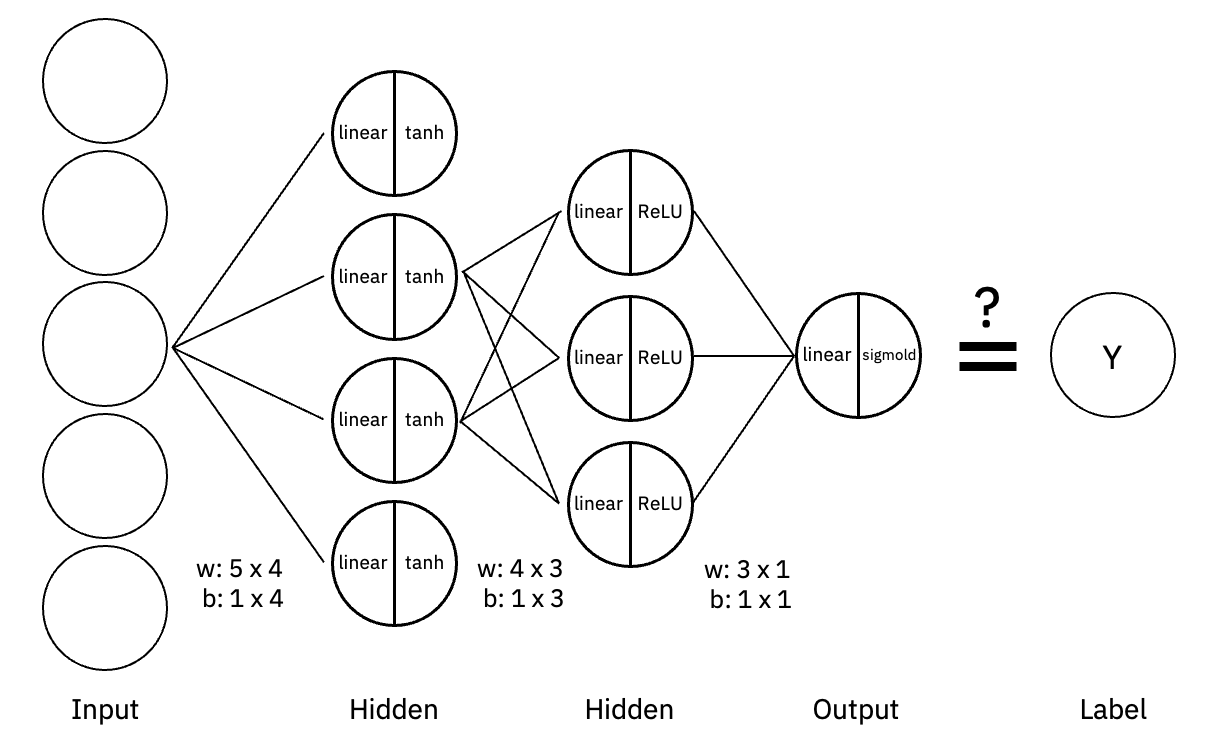

In [5]:
from IPython.display import Image
Image(filename='./figure/NN_rain_prediction.png')

In [6]:
class NN(nn.Module): # for complicate models, this is typically a separate script.
  def __init__(self, n_features):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(n_features, 4)
    self.fc2 = nn.Linear(4, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = torch.tanh(self.fc1(x)) # hidden 1
    x = torch.nn.functional.relu(self.fc2(x)) # hidden 2
    return torch.sigmoid(self.fc3(x))

# initialize the model
model = NN(X_train.shape[1])
print(X_train.shape[1])

5


### 4. Define loss and optimizer

Binary Cross-Entropy Loss:

$
\begin{equation}
L = -\frac{1}{n}\sum_{i=1}^N\Bigg(\Big(y_i \cdot log(\hat{y}_i)\Big) + \Big((1-y_i) \cdot log(1-\hat{y}_i)\Big)\Bigg) \nonumber
\end{equation}
$

where $y_i$ to be actual label (0 or 1), and $\hat{y}_i$ be predicted probability toward $y_i = 1$.

This notebook uses Adam algorithm (https://arxiv.org/abs/1412.6980) for parameter updating. 

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

### 5. Set up device (e.g., GPU)

In [8]:
torch.cuda.is_available() # check if GPU is available

False

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
model = model.to(device)
criterion = criterion.to(device)

### 6. Train the model

In [10]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    # .ge(.5) means "greater of equal to" 0.5
    # .view(-1) is to "view" the tensor (i.e., use the same storage)  
    return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3): 
  # convert tensor back to a number, and round to 3 decimal places
  # t.item() will convert one-element tensor back to a number
  return round(t.item(), decimal_places)

for epoch in range(1001):
    y_pred = model(X_train) # forward propagation
    y_pred = torch.squeeze(y_pred) # make the y_pred tensor more efficient
    train_loss = criterion(y_pred, y_train) # calculate loss
    if epoch % 200 == 0: # print every 200 epochs
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = model(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    train_loss.backward() # backward propagation
    optimizer.step() # update weights
    optimizer.zero_grad() # clear gradient vectors

epoch 0
Train set - loss: 1.008, accuracy: 0.219
Test  set - loss: 1.01, accuracy: 0.218

epoch 200
Train set - loss: 0.493, accuracy: 0.781
Test  set - loss: 0.496, accuracy: 0.782

epoch 400
Train set - loss: 0.454, accuracy: 0.781
Test  set - loss: 0.454, accuracy: 0.782

epoch 600
Train set - loss: 0.424, accuracy: 0.823
Test  set - loss: 0.424, accuracy: 0.823

epoch 800
Train set - loss: 0.405, accuracy: 0.835
Test  set - loss: 0.406, accuracy: 0.834

epoch 1000
Train set - loss: 0.399, accuracy: 0.836
Test  set - loss: 0.4, accuracy: 0.835



### 7. Get parameters

Parameters:
- weights from input layer (5) to the first hidden layer (4): 5 x 4
- biases to the first hidden layer (4): 1 x 4
- weights from the first hidden layer (4) to the second hidden layer (3): 4 x 3
- biases to the second hidden layer (3): 1 x 3
- weights from the second hidden layer (3) to the output layer (1): 3 x 1
- biases to the output hidden layer (1): 1 x 1

Pytorch stores parameters the other way around (transposed).

In [11]:
for layer in list(model.parameters()):
    print(layer.detach().numpy()) # .detach() is needed because gradient is on.
    print(np.shape(layer.detach().numpy()))
    print('')

[[ 0.08625906 -0.5408259  -0.07487424 -0.30176842  0.08786204]
 [-0.24325635  0.45571402  0.28752276  0.23543116 -0.12650426]
 [ 0.37729007 -0.5163793  -0.45613867 -0.08888381  0.14118229]
 [-0.35571682 -0.03101473 -0.0092926  -0.01091773  0.00315451]]
(4, 5)

[-0.5155325  -0.17133181  0.11447822  2.3507981 ]
(4,)

[[-0.3771508   0.3935398  -0.07575836 -0.9127689 ]
 [-0.3173478   0.7211278   0.1104898   1.1494403 ]
 [-0.4508808   0.5970491  -0.21457589  1.7067213 ]]
(3, 4)

[ 0.06895953 -0.04994043  0.02885278]
(3,)

[[ 0.5029519  -0.84762317 -0.59604776]]
(1, 3)

[0.32754275]
(1,)



### 8. Save the model

 - See https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html#save-and-load-the-model for more detail.

In [12]:
MODEL_PATH = './model.pth' # specify path
torch.save(model, MODEL_PATH) # save the model

In [13]:
model2 = torch.load(MODEL_PATH) # load the model

In [14]:
classes = ['No rain', 'Rain']
y_pred = model2(X_test) # test the loaded model
y_pred = y_pred.ge(.5).view(-1)
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.86      0.95      0.90     12376
        Rain       0.70      0.43      0.53      3456

    accuracy                           0.83     15832
   macro avg       0.78      0.69      0.71     15832
weighted avg       0.82      0.83      0.82     15832



For beginners, I would recommend checking online and see how others do. For example: 
- https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2
- https://medium.com/analytics-vidhya/implement-linear-regression-on-boston-housing-dataset-by-pytorch-c5d29546f938
- https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43